# A la recherche de points d'intérêt dans le domaine chiffré

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import skimage
from sympy import randprime
import cv2 as cv

import random
import math

In [2]:
plt.set_cmap('gray')

<Figure size 640x480 with 0 Axes>

## 1: Mise en place du cryptosystème Paillier

### Génération de nombres premiers

#### Méthode probabiliste avec test de Rabin-Miller

La méthode randprime de sympy est plus performante d'un facteur 4-5

### Le cryptosystème de Paillier

In [3]:
class Paillier():
    """
    Cryptosystème de Paillier
    Implémentation des primitives du cryptosystème de Paillier
    """
    class Public_key():
        """
        Public key for the Paillier cryptosystem
        """
        def __init__(self, N : int, g : int):
            self.N = N
            self.g = g
        
    class Private_key():
        """
        Private key for the Paillier cryptosystem
        """
        def __init__(self, l : int):
            self.l = l
    
    def __init__(self,nb_bits : int = 128, public_key : Public_key = None, private_key : Private_key = None):
        """
        params : 
            nb_bits (int) : Nombre de bits de N
            public_key (Public_key) : Clé publique
            private_key (Private_key ): Clé private
        """
        if public_key and private_key :
            
            self.public_key = public_key
            self.private_key = private_key
            
        else :
            
            nb_bits = nb_bits // 2
      
            p = randprime(2 ** (nb_bits-1) + 1, 2 ** nb_bits - 1)
            q = randprime(2 ** (nb_bits-1) + 1, 2 ** nb_bits - 1)

            N = p * q

            #Simplifications
            l = (p - 1) * (q - 1)
            g = N + 1

            self.public_key = self.Public_key(N,g)
            self.private_key = self.Private_key(l)

            self.mu = pow(l, -1, N)
        
    def L(self,u : int):
        return (u-1) // self.public_key.N
    
    def random_prime_in_N(self):
        """
        Génére un nombre premier dans [0,N-1]
        """
        return randprime(0, self.public_key.N - 1)
    
    def encrypt(self, m : int, r : int = None):
        """
        Chiffre le message m avec r choisi uniformément dans Z_n
        """
        assert m < self.public_key.N
        if not r :
            r = self.random_prime_in_N()
        
        return (pow(self.public_key.g,m,self.public_key.N ** 2) * pow(r,self.public_key.N,self.public_key.N ** 2)) % (self.public_key.N ** 2)
             
    def decrypt(self, c : int):
        """
        Déchiffre le texte chiffré en paramètre
        """
        return (self.L(pow(c, self.private_key.l, self.public_key.N ** 2)) * self.mu ) % self.public_key.N
    
    def add(self, c1 : int, c2 : int):
        """
        Opération addition dans le domaine chiffré
        """
        return (c1 * c2) % (self.public_key.N ** 2)
    
    def add_constant(self, c1, constant : int):
        """
        Opération addition d'une constante à un nombre chiffré
        """
        return c1 * pow(self.public_key.g, constant, self.public_key.N ** 2) % self.public_key.N ** 2
    
    def multiply(self, c1 : int , constant : int):
        """
        Multiplication par une constante d'un nombre chiffré
        """
        return modpow(c1, constant, self.public_key.N ** 2)
        

### Chiffrement d'images

In [4]:
def chiffre_image(image,paillier : Paillier,r = None):
    """
    Chiffre une image avec le cryptosystéme de Paillier
    """
    return np.array([paillier.encrypt(i,r) for i in np.array(image.flatten(),dtype = object)]).reshape(image.shape)

def dechiffre_image(image_cryptee,paillier : Paillier):
    """
    Déchiffre une image chiffrée avec le cryptosystème de Paillier
    """
    return np.array(list(map(paillier.decrypt,image_cryptee.ravel())),dtype = np.uint8).reshape(image_cryptee.shape)

def normalise_gris_image(image_cryptee,public_key : Paillier.Public_key):
    """
    Normalise les valeurs de l'image chiffrée en niveau de gris (0 à 255)
    """
    return np.array(image_cryptee / public_key.N ** 2 * 255,dtype = np.uint8)
    

### Tests

In [5]:
cam = skimage.data.camera()
paillier = Paillier(64)

In [6]:
%%time
cam_chiffre = chiffre_image(cam,paillier)

CPU times: user 10.2 s, sys: 9.77 ms, total: 10.2 s
Wall time: 10.2 s


In [7]:
%%time
cam_dechiffre = dechiffre_image(cam_chiffre,paillier)

CPU times: user 3.17 s, sys: 204 µs, total: 3.17 s
Wall time: 3.17 s


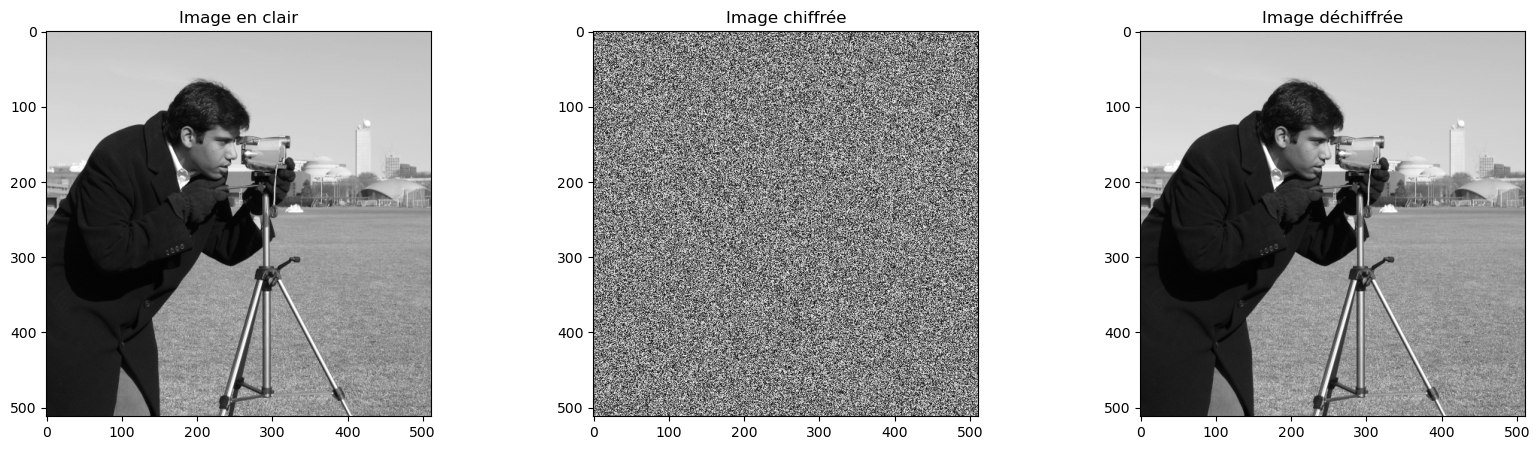

In [8]:
fig, axes = plt.subplots(1,3,figsize=(20,5))
axes = axes.flatten()
axes[0].imshow(cam,cmap='gray')
axes[0].set_title('Image en clair')
axes[1].imshow(normalise_gris_image(cam_chiffre,paillier.public_key),cmap = 'gray')
axes[1].set_title('Image chiffrée')
axes[2].imshow(cam_dechiffre,cmap = 'gray')
axes[2].set_title('Image déchiffrée')
plt.show()

In [9]:
from skimage.util import compare_images
np.sum(compare_images(cam,cam_dechiffre))

0.0

Il n'y a aucune perte lors du chiffrement/dechiffrement par rapport à l'image de base.

Problèmes rencontrés :

* Temps de calcul lors du chiffrement des images

    * Utilisation sympy pour générer des nombres premiers plus rapidement



## 2: Mise en place de la méthode SIFT

In [10]:
def convolution_2d(image, kernel, padding = 0, padding_value = 0):
    """
    Renvoi le produit de convolution de l'image et du noyau en appliquant un padding si besoin
    """
    image = np.pad(image,[(padding,padding),(padding,padding)],constant_values = padding_value)
    
    output_shape = (image.shape[0] - kernel.shape[0] + 1, image.shape[1] - kernel.shape[1] + 1)
    output = np.zeros(output_shape,dtype = image.dtype)
    
    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            portion = image[i : i + kernel.shape[0], j : j + kernel.shape[1]]
            output[i,j] = np.sum(portion * kernel)
            
    return output
            
def kernel_gauss(l = 5, sig = 1):
    """
    Créer le kernel de la Gaussienne de paramètre sigma et de taille l*l
    """
    ax = np.linspace(-(l - 1) / 2, (l - 1) / 2, l,dtype = np.float64)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

### Détecteur SIFT

In [11]:
from numpy import all, any, array, arctan2, cos, sin, exp, dot, log, logical_and, roll, sqrt, stack, trace, unravel_index, pi, deg2rad, rad2deg, where, zeros, floor, full, nan, isnan, round, float32
from numpy.linalg import det, lstsq, norm
from cv2 import KeyPoint
from functools import cmp_to_key

In [12]:
class SIFT():
    """
    Implémentation du Scale Invariant Feature Transform
    """
    BORDER_WIDTH = 5
    EIG_VALUES_RATIO = 10
    GAUSSIAN_KERNEL_SIZE = 7
    
    def __init__(self, n_octaves = 3, n_scales = 6, sigma = 1.4, threshold = 1, contrast_threshold = 0.1, nb_essais = 10, upscale = False):
        self.n_octaves = n_octaves
        self.n_scales = n_scales
        self.sigma = sigma
        self.contrast_threshold = contrast_threshold
        self.nb_essais = nb_essais
        
        self.gaussian_kernel = self.generateGaussianKernels()
        self.upscale = upscale
        
        self.threshold = threshold
        self.threshold = floor(0.5 * contrast_threshold / n_scales * 255)  # from OpenCV implementation
        
    def generateGaussianKernels(self):
        """
        Génére une liste de variance pour les noyaux Gaussien de manière à avoir une octave complète avec le nombre d'image
        """
        k = 2 ** (1. / self.n_scales)
        gaussian_kernels = zeros(self.n_scales)
        gaussian_kernels[0] = self.sigma

        for image_index in range(1, self.n_scales):
            sigma_previous = (k ** (image_index - 1)) * self.sigma
            sigma_total = k * sigma_previous
            gaussian_kernels[image_index] = sqrt(sigma_total ** 2 - sigma_previous ** 2)
            
        return gaussian_kernels
        
    def detect(self, image):
        """
        Fonction principale de l'algorithme
        Detecte les points d'intérêts sur l'image passé en paramètre
        """                                          
        image = np.array(image,dtype = np.int64)
        
        # Méthode 1:
        pyramid = self.build_scales(image)
        dogs = self.differences_of_gaussian(pyramid)
        
        # Méthode 2 :
        dogs = self.differences_of_gaussian_v2(image)
        
        keypoints = self.keypoint_localisation(dogs)
        
        # Méthode non utilisée car très couteuse
        #keypoints = self.removeDuplicateKeypoints(keypoints)

        return keypoints
        
        
    def build_scales(self, image) :
        """
        Création de la pyramide d'image floutées de forme (n_octaves,n_scales)
        Créer les différentes octaves en divisant/multipliant par 2 la taille de l'image
        Applique un flou Gaussien croissant à chaque image
        
        Les convolutions utilisent un padding de 1 qui semble avoir une incidence positive sur les résultats de l'algorithme
        """
        pyramid = []
        kernel = self.generateGaussianKernels()
        

        for i in range(self.n_octaves) :
            scales = []
            
            if i > 0 :
                if self.upscale : 
                    im = skimage.transform.resize(im,np.array(image.shape) * 2)
                else :
                    im = skimage.transform.resize(im,np.array(image.shape) // 2)
            else :
                im = image

            for j in range(self.n_scales) :
                kgauss = kernel_gauss(self.GAUSSIAN_KERNEL_SIZE, self.gaussian_kernel[j])
                blurred_image = convolution_2d(im, kgauss, self.GAUSSIAN_KERNEL_SIZE // 2, 1)
                scales += [blurred_image]          

            pyramid += [scales]

        return pyramid

    def differences_of_gaussian(self,pyramid):
        """
        Calcule la différence des Gausiennes des différentes images floutées
        """
        dogs = []
        for i in range(self.n_octaves) :
            dog = []
            for j in range(self.n_scales - 1) :
                dog += [(pyramid[i][j+1] - pyramid[i][j])]
                
            dogs += [dog]
        return dogs
    
    def differences_of_gaussian_v2(self,image):
        """
        Version plus rapide de la différence des gaussiennes.
        Fait une convolution de l'image avec la différence du noyau Gaussien,
        ce qui économise plus de la moitiée des calculs effectué par la première méthode.
        
        (Non utilisée pour l'instant car j'ai déterminé les meilleurs paramètre avec l'ancienne méthode et
        le changement de calcul provoque une légère différence dans le résultat)
        """
        sigmas = self.generateGaussianKernels()
        pyramid = []
        
        for ind_octave in range(self.n_octaves):
            
            if ind_octave > 0 :
                if self.upscale : 
                    im = skimage.transform.resize(im,np.array(image.shape) * 2)
                else :
                    im = skimage.transform.resize(im,np.array(image.shape) // 2)
            else :
                im = image
            
            dogs = []
            
            for ind_scale in range(self.n_scales - 1):
                
                kernel = kernel_gauss(self.GAUSSIAN_KERNEL_SIZE,sigmas[ind_scale + 1]) - kernel_gauss(self.GAUSSIAN_KERNEL_SIZE,sigmas[ind_scale])
                dogs += [convolution_2d(im,kernel,self.GAUSSIAN_KERNEL_SIZE // 2, 1)]
            
            pyramid += [dogs]
        return pyramid

    def keypoint_localisation(self,pyramid_dogs):
        """
        Localise les points d'interêts à partir des différences des Gausiennes
        """
        keypoints = []
        for ind_octave,octave in enumerate(pyramid_dogs) :
            
            maxx = pyramid_dogs[ind_octave][0].shape[0]
            maxy = pyramid_dogs[ind_octave][0].shape[1]
                
            for ind_dog,(i1,i2,i3) in enumerate(zip(octave[:],octave[1:],octave[2:])) : # Pour chaque groupe de 3 images

                for x in range(self.BORDER_WIDTH, maxx - self.BORDER_WIDTH):
                    for y in range(self.BORDER_WIDTH, maxy - self.BORDER_WIDTH):

                        current = pyramid_dogs[ind_octave][ind_dog][x,y]

                        if abs(current) < self.threshold :
                            continue

                        voisinnage = np.stack((i1[x-1:x+2, y-1:y+2], i2[x-1:x+2, y-1:y+2], i3[x-1:x+2, y-1:y+2]))

                        if self.est_extremum(current,voisinnage):
                            loc = self.localise_extremums(x, y, voisinnage, ind_dog + 1, ind_octave, i1.shape)
                            if loc != None:
                                keypoint, localized_image_index = loc
                                keypoints += [keypoint]
                                
                                # Ajouter les directions ?
        return keypoints
    
    
    def localise_extremums(self,i, j, voisinage, image_index, octave_index, image_shape):
        """
        Localise les extremums et construit les objets keypoint correspondant
        num intervals = n_scales
        """
        converge = False

        for essai in range(self.nb_essais):

            gradient = self.computeGradientAtCenterPixel(voisinage)
            hessian = self.computeHessianAtCenterPixel(voisinage)
        
            extremum_update = -lstsq(hessian, gradient, rcond=None)[0]

            if abs(extremum_update[0]) < 0.5 and abs(extremum_update[1]) < 0.5 and abs(extremum_update[2]) < 0.5: #vérifier valeur en clair
                converge = True
                break

            i += int(round(extremum_update[1]))
            j += int(round(extremum_update[0]))
            image_index += int(round(extremum_update[2]))


        # Si pas dans image / image n'existe pas / l'algo n'a pas convergé
        if (not converge or 
        i < self.BORDER_WIDTH or i >= image_shape[0] - self.BORDER_WIDTH or
        j < self.BORDER_WIDTH or j >= image_shape[1] - self.BORDER_WIDTH or
        image_index < 1 or image_index > self.n_scales):
            return None


        functionValueAtUpdatedExtremum = voisinage[1, 1, 1] + 0.5 * np.dot(gradient, extremum_update)
        if np.abs(functionValueAtUpdatedExtremum) * self.n_scales >= self.contrast_threshold: # vérifier bien n_scales
            xy_hessian = hessian[:2, :2]
            xy_hessian_trace = trace(xy_hessian)
            xy_hessian_det = det(xy_hessian)

            if xy_hessian_det > 0 and self.EIG_VALUES_RATIO * (xy_hessian_trace ** 2) < ((self.EIG_VALUES_RATIO + 1) ** 2) * xy_hessian_det:

                # On construit un objet Keypoint d'open CV
                keypoint = KeyPoint()
                keypoint.pt = ((j + extremum_update[0]) * (2 ** octave_index), (i + extremum_update[1]) * (2 ** octave_index))
                keypoint.octave = octave_index + image_index * (2 ** 8) + int(round((extremum_update[2] + 0.5) * 255)) * (2 ** 16)
                keypoint.size = self.sigma * (2 ** ((image_index + extremum_update[2]) / float32(self.n_scales))) * (2 ** (octave_index + 1))
                keypoint.response = np.abs(functionValueAtUpdatedExtremum)
                return keypoint, image_index
            
        return None
    
    @staticmethod
    def computeGradientAtCenterPixel(pixel_array):
        """
        Approximate gradient at center pixel [1, 1, 1] of 3x3x3 array using central difference formula of order O(h^2), where h is the step size
        """
        dx = 0.5 * (pixel_array[1, 1, 2] - pixel_array[1, 1, 0])
        dy = 0.5 * (pixel_array[1, 2, 1] - pixel_array[1, 0, 1])
        ds = 0.5 * (pixel_array[2, 1, 1] - pixel_array[0, 1, 1])
        return array([dx, dy, ds])

    @staticmethod
    def computeHessianAtCenterPixel(pixel_array):
        """
        Approximate Hessian at center pixel [1, 1, 1] of 3x3x3 array using central difference formula of order O(h^2), where h is the step size
        """
        center_pixel_value = pixel_array[1, 1, 1]
        dxx = pixel_array[1, 1, 2] - 2 * center_pixel_value + pixel_array[1, 1, 0]
        dyy = pixel_array[1, 2, 1] - 2 * center_pixel_value + pixel_array[1, 0, 1]
        dss = pixel_array[2, 1, 1] - 2 * center_pixel_value + pixel_array[0, 1, 1]
        dxy = 0.25 * (pixel_array[1, 2, 2] - pixel_array[1, 2, 0] - pixel_array[1, 0, 2] + pixel_array[1, 0, 0])
        dxs = 0.25 * (pixel_array[2, 1, 2] - pixel_array[2, 1, 0] - pixel_array[0, 1, 2] + pixel_array[0, 1, 0])
        dys = 0.25 * (pixel_array[2, 2, 1] - pixel_array[2, 0, 1] - pixel_array[0, 2, 1] + pixel_array[0, 0, 1])
        return array([[dxx, dxy, dxs], 
                      [dxy, dyy, dys],
                      [dxs, dys, dss]])


    # OPERATIONS KEYPOINTS

    @staticmethod
    def compareKeypoints(keypoint1, keypoint2):
        """
        Utiliser pour ranger les objets keypoint avec la fonction sort
        """
        if keypoint1.pt[0] != keypoint2.pt[0]:
            return keypoint1.pt[0] - keypoint2.pt[0]
        if keypoint1.pt[1] != keypoint2.pt[1]:
            return keypoint1.pt[1] - keypoint2.pt[1]
        if keypoint1.size != keypoint2.size:
            return keypoint2.size - keypoint1.size
        if keypoint1.angle != keypoint2.angle:
            return keypoint1.angle - keypoint2.angle
        if keypoint1.response != keypoint2.response:
            return keypoint2.response - keypoint1.response
        if keypoint1.octave != keypoint2.octave:
            return keypoint2.octave - keypoint1.octave
        return keypoint2.class_id - keypoint1.class_id

    @staticmethod
    def removeDuplicateKeypoints(keypoints):
        """
        Trie les keypoints et supprime les doublons 
        """
        if len(keypoints) < 2:
            return keypoints

        keypoints.sort(key=cmp_to_key(compareKeypoints))
        unique_keypoints = [keypoints[0]]

        for next_keypoint in keypoints[1:]:
            last_unique_keypoint = unique_keypoints[-1]

            if not(next_keypoint.pt[0] == last_unique_keypoint.pt[0] and last_unique_keypoint.pt[1] == next_keypoint.pt[1]):
                unique_keypoints += [next_keypoint]

        return unique_keypoints


    @staticmethod
    def est_extremum(val : int, table):
        """
        Prédicat, renvoi vrai si val est soit plus grand ou égal, soit plus petit ou égal que toutes les autres valeurs de table
        """
        sup = True
        inf = True
        for i in range(table.shape[0]):
            for j in range(table.shape[1]):
                for k in range(table.shape[2]):
                    if not (sup or inf) :
                        return False
                    if val < table[i,j,k] :
                        sup = False
                    if val > table[i,j,k] :
                        inf = False
                        
        return sup or inf
        

In [13]:
sif = SIFT()
sif.generateGaussianKernels()

array([1.4       , 0.71375434, 0.80116216, 0.89927412, 1.00940107,
       1.13301439])

### Test du SIFT en clair

In [14]:
def affiche_images_et_keypoints(images : list, params : dict = None, compare_cv : bool = False):
    """
    Affiche l'image de base, le résultat de mon sift et le résultat du sift de cv si compare_cv = True
    sift_results contient des dictionnaires à 2 entrées {'image','keypoints'}
    """
    sift = SIFT(**params)
    if compare_cv :
        
        fig,axes = plt.subplots(len(images), 3,figsize = (20,6 * len(images)))
        features = cv.SIFT_create()
        
    else : 
        
        fig,axes = plt.subplots(len(images), 2,figsize = (15,5 * len(images)))
        
    for ind, image in enumerate(images) :
        keypoints = sift.detect(image)
        axes[ind][0].imshow(image,cmap = 'gray')
        axes[ind][0].set_title('image de reférence')
        axes[ind][1].imshow(cv.drawKeypoints(image, keypoints, 0, (255, 0, 0), flags=cv.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS))
        axes[ind][1].set_title('Résultat mySIFT')
        
        if compare_cv :
            axes[ind][2].imshow(cv.drawKeypoints(image,features.detect(image, None) , 0, (255, 0, 0), flags=cv.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS))
            axes[ind][2].set_title('Résultat SIFT opencv')
            
    plt.show()

In [15]:
# Génération des collection d'images

test_images_gray = [
    skimage.data.coins(),
    skimage.data.page(),
    skimage.data.text()
]
test_images_rgb = [
    skimage.data.cat(),
    skimage.data.coffee(),
    skimage.data.rocket()
]

test_images_gray += [cv.cvtColor(i,cv.COLOR_RGB2GRAY) for i in test_images_rgb]

### Tests

Meilleurs paramètres trouvés :  
* réduction de moitiée pour chaque octave
* nb_essais : 15
* n_scales : 6  
* threshold : 0.35
* sigma : 3

## 3: SIFT dans le domaine chiffré

Le sift d'open CV n'accepte pas les entiers naturels de python, on ne peut donc pas effectuer de sift dans le domaine chiffré avec open_cv.

In [16]:
def shape(l : list):
    """
    Renvoi la forme de la liste
    Suppose que tout les éléments d'une liste aient la même forme que le premier élément
    """
    res = []
    while type(l) == list :
        res += [len(l)]
        l = l[0]
    return tuple(res)

def downscale_by_2(l : list):
    """
    Divise par 2 la taille d'une image en longueur et en largeur
    """
    assert(len(shape(l)) == 2)
    l_shape = shape(l)
    
    output = []
    for i in range(0,l_shape[0],2) :
        line = []
        for j in range(0,l_shape[1],2) :     
            line += [l[i][j]]
        output += [line]
    return output

def convert_numpy_to_list(array):
    """
    Converti un array numpy en liste d'entiers
    """
    assert(len(array.shape) == 2)
    output = []
    for i in range(array.shape[0]):
        line = []
        for j in range(array.shape[1]):
            line += [int(array[i,j])]
        output += [line]
    return output
            

In [17]:
class CipherSIFT(SIFT):
    """
    SIFT dans le domaine chiffré
    Listes d'ints ?
    
    Attentions au méthodes qui convertissent en float
    Pour le kernel de gauss, utiliser le scaling factor , et convertir en int le résultat, on accepte une marge d'erreur --> la vérifier
    Vérifier pour des grands nombres qu'il n'y ai pas une trop grosse marge d'erreur
    Vérifier les différences entre 2 convertions ints du kernel de gauss avec le scaling factor
    """
    def __init__(self, paillier, scaling_factor = 10 ** 6, **kwargs):
        self.paillier = paillier
        self.scaling_factor = scaling_factor
        super(CipherSIFT,self).__init__(**kwargs)
        
        self.gdiff_kernels = self.generate_gdiff()
        
    def generate_gdiff(self):
        """
        Génére les noyaux issus de la différence des noyaux gaussiens entre chaque echelle de flou
        Garder ici la mutiplication scaling_factor ?
        """
        sigmas = np.array(self.generateGaussianKernels())
        gdiff_list = []
        
        for ind_scale in range(self.n_scales - 1):  
            
            gdiff = (kernel_gauss(self.GAUSSIAN_KERNEL_SIZE,sigmas[ind_scale + 1]) - kernel_gauss(self.GAUSSIAN_KERNEL_SIZE,sigmas[ind_scale]))  
            gdiff *= self.scaling_factor
            
            gdiff = np.array(convert_numpy_to_list(np.round(gdiff)),dtype = object)
            gdiff_list += [gdiff]
        
        return gdiff_list
        
    def detect(self,image):
        """
        Fonction principale
        """
        pyramid_dogs = self.differences_of_gaussian(image)
                
        return pyramid_dogs 
    
    
    def differences_of_gaussian(self,image):
        """
        Calcule la différence des Gausiennes des différentes images
        octaves[scales[np.array]]
        """
        pyramid = []
        
        for ind_octave in range(self.n_octaves):
            
            if ind_octave > 0 :
                if self.upscale : 
                    im = skimage.transform.resize(im,np.array(image.shape) * 2)
                else :
                    im = skimage.transform.resize(im,np.array(image.shape) // 2)
            else :
                im = image
            
            dogs = []
            
            for ind_scale in range(self.n_scales - 1):   
                    
                kernel = self.gdiff_kernels[ind_scale]
                   
                dog = convolution_2d_chiffre(im,kernel,self.paillier.public_key,self.GAUSSIAN_KERNEL_SIZE // 2, 1)
                
                dogs += [dog]
            
            pyramid += [dogs]
        return pyramid
    
    def generate_thresholds(self,nb_tresholds = 255):
        l = [[] for ind_scale in range(self.n_scales -1) ]

        for ti in range(nb_tresholds) :
            for ind_scale in range(self.n_scales -1) :
                
                k = self.gdiff_kernels[ind_scale]
                res = 1
                
                for ki in k.flatten() :
                    r = self.paillier.random_prime_in_N()
                    res = (res * pow(r,ki,self.paillier.public_key.N ** 2)) % (self.paillier.public_key.N ** 2)
                    l[ind_scale] += [self.paillier.encrypt(ti,res)]
        return l
    
    def keypoint_localisation(self,image):
        pass
        

In [18]:
def pad(l,padding = 1, value = 0):
    """
    ajout de padding sur liste python
    """
    if type(l[0]) == list :
        shape = (len(l),len(l[0]))
    else :
        shape = (len(l))
    
    output = []
    for i in range(padding) :
        output += [[value for j in range(shape[1] + 2 * padding)]]
        
    for i in range(shape[0]):
        output += [[value for j in range(padding)] + l[i] + [value for j in range(padding)]]
    
    for i in range(padding) :
        output += [[value for i in range(shape[1] + 2 * padding)]]
    
    return output

In [19]:
def convolution_2d_chiffre(image, kernel, public_key, padding = 0, padding_value = 0):
    """
    Renvoi le produit de convolution de l'image et du noyau en appliquant un padding si besoin
    """
    image = np.array(pad(image.tolist(),padding = padding, value = padding_value),dtype = object)
    
    output_shape = (image.shape[0] - kernel.shape[0] + 1, image.shape[1] - kernel.shape[1] + 1)
    output = np.ones(output_shape,dtype = object)
    
    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            
            portion = image[i : i + kernel.shape[0], j : j + kernel.shape[1]]
            
            res = 1
            for im, k in zip(portion.flatten() , kernel.flatten()):
            
                res = (res * pow(im,k,public_key.N ** 2)) % (public_key.N ** 2)
                
            output[i,j] = res
            
    return output

def add_table(t1,t2,paillier):
    output = np.array(t1)
    for i in range(t1.shape[0]):
        for j in range(t1.shape[1]):
            output[i,j] = paillier.add(t1[i,j],t2[i,j])
    return output

In [20]:
im = skimage.data.coins()

In [21]:
paillier = Paillier(32)
im_c = chiffre_image(im,paillier)

In [22]:
sift = CipherSIFT(
    paillier = paillier,
    scaling_factor= 10 ** 4,
    n_octaves=1,
    n_scales=4,
    sigma = 1.6,
    contrast_threshold=0.15
)

In [23]:
%%time
sift_res = sift.detect(im_c)

CPU times: user 31.9 s, sys: 22.9 ms, total: 31.9 s
Wall time: 32 s


In [24]:
tresholds = sift.generate_thresholds()

### Tests

In [25]:
def chiffre_images(images : list(),nb_bits = 64):
    """
    Chiffre les images entrées en paramètre avec le cryptosystème de Paillier en nb_bits bits
    """
    images_chiffrees = []
    for i in images :
        paillier = Paillier(bits)
        images_chiffrees += [
            {
            'image_base' : i,
            'image_chiffree' : chiffre_image(i,paillier),
            'public_key' : paillier.public_key,
            'private_key' : paillier.private_key}
        ]
    return images_chiffrees

## 4: Apprentissage d'un réseau de neuronnes à extraire des points d'interêts

### Préparation des données

In [26]:
def keypoints_to_coordinates(keypoints):
    """
    Converti une liste de KeyPoints en np array qui correspond à des coordonnées (x,y)
    """
    output = []
    for k in keypoints :
        output += [k.pt]
    return np.array(output)

def coordinates_to_keypoints(coordinates):
    """
    Converti un np array en liste de KeyPoints
    """
    output = []
    for c in coordinates.tolist() :
        keypoint = KeyPoint()
        keypoint.pt = (c[0],c[1])
        output += [keypoint]
    return output

In [27]:
def create_image_of_keypoint(kp_list,shape):
    """
    Créé le tableau de sortie de notre réseau de neuronnes à partir des points d'intêrets
    1 quand on a un point d'intérêt, 0 sinon
    Faire une matrice sparse plutôt
    """
    kpts = np.array(kp_list,dtype = int) # abcisse / ordonnées
    kpts = np.flip(kpts,axis = 1) # Flip sur l'axe 1
    output = np.zeros(shape,dtype = np.uint8)
    output[kpts[:,0],kpts[:,1]] = 100
    return output

def create_keypoints_of_image(image,threshold):
    """
    Créé la liste de keypoints à partir d'une représentation de probabilités
    """
    output = []
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i,j] >= threshold :
                #output += [j,i] # un keypoint est (x,y)
                kp = KeyPoint()
                kp.pt = (j,i)
                output += [kp]
    return output



### CNN

Idée : Réseau de neuronnes convolutif dont le but est d'apprendre à extraire les points d'intérêts sous forme d'une représentation de probabilité de présence de point d'intêrets de la forme de l'image.

In [28]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
torch.device('cpu')

device(type='cpu')

In [29]:
import torch.optim as optim

def training(net,trainloader,loss_function,lr = 0.00001,nb_iter = 50,verbose = False):

    criterion = loss_function
    optimizer = optim.Adam(net.parameters(), lr=lr)

    net.train()
    for epoch in range(nb_iter):

        running_loss = 0.0
        
        for i, data in enumerate(trainloader):
            inputs, labels = data

            outputs = net.forward(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            running_loss += loss.item()
            if i % 50 == 49 and verbose:  
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 50))
                running_loss = 0.0
                
    return net

def evaluate(net,dataloader):
    net.eval()
    
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            inputs, targets = data

            outputs = net.forward(inputs)
            
            # Accuracy
            # Precision
            # Recall

In [30]:
class FeatureDetectorCNN(nn.Module):
    def __init__(self, lr=0.1):
        super(FeatureDetectorCNN, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.LazyConv2d(64, kernel_size=3, stride=1, padding=1), nn.ReLU(), nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            
            nn.LazyConv2d(64, kernel_size=3, stride=1, padding=1), nn.ReLU(), nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            
            nn.LazyConv2d(64, kernel_size=3, stride=1, padding=1), nn.ReLU(), nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            
            nn.LazyConv2d(256, kernel_size=3, stride=1, padding=1), nn.ReLU(), nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            
            nn.LazyConv2d(256, kernel_size=3, stride=1, padding=1), nn.ReLU(), nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            
            nn.LazyConv2d(256, kernel_size=3, stride=1, padding=1), nn.ReLU(), nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            
        )     
        self.decoder = nn.Sequential(  
            nn.LazyConvTranspose2d(256,kernel_size=3,stride=1, padding = 1), nn.ReLU(),
            nn.LazyConvTranspose2d(2,kernel_size=2,stride=2), nn.ReLU(),
            
            nn.LazyConvTranspose2d(256,kernel_size=3,stride=1, padding = 1), nn.ReLU(),
            nn.LazyConvTranspose2d(2,kernel_size=2,stride=2), nn.ReLU(),
            
            nn.LazyConvTranspose2d(256,kernel_size=3,stride=1, padding = 1), nn.ReLU(),
            nn.LazyConvTranspose2d(2,kernel_size=2,stride=2), nn.ReLU(),
            
            nn.LazyConvTranspose2d(256,kernel_size=3,stride=1, padding = 1), nn.ReLU(),
            nn.LazyConvTranspose2d(2,kernel_size=2,stride=2), nn.ReLU(),

            nn.LazyConvTranspose2d(64,kernel_size=3,stride=1,padding = 1), nn.ReLU(),
            nn.LazyConvTranspose2d(2,kernel_size=2,stride=2), nn.ReLU(),

            nn.LazyConvTranspose2d(64,kernel_size=3,stride=1,padding = 1), nn.ReLU(),
            nn.LazyConvTranspose2d(2,kernel_size=2,stride=2), nn.ReLU(),
            
            nn.LazyConvTranspose2d(64,kernel_size=3,stride=1,padding = 1), nn.ReLU(),
            nn.LazyConvTranspose2d(2,kernel_size=2,stride=2), nn.ReLU(),
            
            nn.LazyConvTranspose2d(64,kernel_size=3,stride=1,padding = 1), nn.ReLU(),
            nn.LazyConvTranspose2d(2,kernel_size=2,stride=2), nn.ReLU(),
            
            nn.LazyConv2d(1, kernel_size=1, stride=1, padding=0), 
            nn.Softmax2d()
)
        
    def forward(self,x):
        x = self.encoder(x)
        x = x.reshape([1,256,8,8])
        return self.decoder(x)


### Préparation du dataset :

* 1: Normalisation taille et conversion en niveaux de gris --> save
* 2: SIFT --> save json {nom_fichier, resultat_sift}
* 3: Tenseur des images / Tenseur des points d'interêts --> apprentissage

In [31]:
STANDARDIZED_DIR = 'images/standardized/'

In [32]:
import os
import json

def standardize_dataset(path,verbose = False):
    files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    for f in files :
        image = cv.imread('images/dataset/'+f,cv.IMREAD_GRAYSCALE)
        image = cv.resize(image,(512,512))
        cv.imwrite('images/standardized/'+f,image)
        if verbose :
            plt.imshow(image)
            plt.title(f)
            plt.show()
        
def apply_and_store_sift(path,sift,verbose = False):
    """
    Faire un json à deux entrées : 
        - image_name : str
        - sift_results : list (x,y)
    """
    files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    results = []
    
    for f in files :
        image = cv.imread(path+f,cv.IMREAD_GRAYSCALE)
        keypoints = sift.detect(image)
        kp_list = keypoints_to_coordinates(keypoints)
        results += [{'image_name' : f, 'sift_results' : kp_list.tolist()}]

        if verbose:
            sift_image = cv.drawKeypoints(image, keypoints, 0, (255, 0, 0), flags=cv.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
            plt.imshow(sift_image)
            plt.title(f)
            plt.show()
            
    with open('sift_results.json', encoding="UTF-8", mode="w") as f:
                json.dump(results, f, indent="    ")
    
    return results

def get_data_from_json(path_images):
    with open('sift_results.json', encoding="UTF-8", mode="r") as f:
                results = json.load(f)
            
    sifts = [np.array(res['sift_results']) for res in results]
    images = [res['image_name'] for res in results]
    
    return images,sifts
        

In [33]:
class MyDataset(Dataset):
    def __init__(self, img_dir,image_labels,targets):
        self.targets = targets
        self.img_labels = image_labels
        self.img_dir = img_dir

    def __len__(self):
        return len(self.targets)
        #return 1

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels[idx])
        image = cv.imread(img_path,cv.IMREAD_GRAYSCALE)
        target = self.targets[idx]
        target = create_image_of_keypoint(target,image.shape)
        
        image = torch.tensor(image[np.newaxis,:,:],dtype = torch.float,)
        target = torch.tensor(target[np.newaxis,:,:],dtype = torch.float)
        
        return image, target

AVEC MNIST

In [34]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image

In [35]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])
#transform = transforms.Compose([transforms.ToTensor(), torch.divide(self,1)])
trainset = tv.datasets.MNIST(root='./data',  train=True,download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=False, num_workers=4)
testset = tv.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

In [36]:
class MNIST_sift(Dataset):
    def __init__(self,images, sift,transf):
        self.sift = sift
        self.images = tv.datasets.MNIST(root='./data',  train=True,download=True).data
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = sift.detect(image)
        target = create_image_of_keypoint(target,image.shape)
        
        image = torch.tensor(image[np.newaxis,:,:],dtype = torch.float,)
        target = torch.tensor(target[np.newaxis,:,:],dtype = torch.float)
        
        return image, target

In [37]:
class Autoencoder(nn.Module):

    def __init__(self):
        super(Autoencoder,self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5),
            nn.ReLU(True),
            nn.Conv2d(6,16,kernel_size=5),
            nn.ReLU(True),
        )


        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16,6,kernel_size=5),
            nn.ReLU(True),
            nn.ConvTranspose2d(6,1,kernel_size=5),
            nn.ReLU(True),
            nn.Sigmoid())

    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [38]:
def train():
    num_epochs = 3
    model = Autoencoder().cpu()
    distance = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)

    for epoch in range(num_epochs):
        for data in dataloader:
            img, _ = data
            img = Variable(img).cpu()
            # ===================forward=====================
            output = model(img)
            loss = distance(output, img)
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))
    return model
    

In [ ]:
model = train()

In [ ]:
with torch.no_grad():
    i = 0
    for data in testloader :
        img, target = data
        print("EXEMPLE :",i)
        print(img, model.forward(img))
        print((img == model.forward(img)).sum() / img.shape[2] * img.shape[3])
        i += 1
        if i == 5 :
            break
        

## 5: Résultats

TODO :
* SIFT domaine chiffré
    * méthode des moindres carrés à refaire domaine chiffré
    * Génération des thresholds
    
* Script chiffrement images
    * Pouvoir récupérer tuple (image, ciphertext, clé_publique, clé_privée)
    
* Faire des matrices sparse pour stocker représentation des points d'intérêts

Problèmes :
* CNN ne converge pas
* batch de taille 1 uniquement